In [127]:
import geopandas as gpd
import numpy as np
import pandas as pd

# Calculating heatmap

### Define input variables
gdf : land_uses data

unit : spatial area to group (grid/hex/block)

In [128]:
select_unit = 'hex'
default_crs = '32718'
scenario = 'actual'
# scenario = 'future'


In [129]:
# Load input data
gdf = gpd.read_file(f'/app/assets/land_uses/{scenario}')
unit = gpd.read_file(f'/app/assets/groupby/{select_unit}')

In [130]:
# Preprocess land_uses
gdf['Uso'] = gdf['Uso'].fillna('NO INFORMADO')
mask = gdf['Uso'].isin(['NO INFORMADO', 'SIN INFORMACIÓN'])
gdf.loc[mask, 'Uso'] = 'OTROS'
gdf['area_predio'] = gdf.area

In [131]:
# Preprocess unit
unit['area_unit'] = unit.area

##### Start processing data

In [132]:
# Intersection between land_uses and units
intersection = gpd.sjoin(unit, gdf, how="inner", op="intersects")
intersection['area'] = intersection.area

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [133]:
# Filter intersection geodataframe by columns
inter_cols = [f'{select_unit}_id', 'Uso', 'area', 'area_unit', 'area_predio']
intersection = intersection[inter_cols]

total_inter_area = intersection.groupby([f'{select_unit}_id'])['area'].agg('sum').reset_index().rename(columns={'area': 'inter_area'})
intersection = pd.merge(intersection, total_inter_area, on=f'{select_unit}_id')
intersection['property_percentage'] = intersection['area']/intersection['inter_area']
intersection['information_per_property'] = -1*intersection['property_percentage']*np.log(intersection['property_percentage'])
diversity = intersection.groupby(f'{select_unit}_id')['information_per_property'].agg('sum').reset_index()
diversity_map = pd.merge(diversity, unit, on=f'{select_unit}_id')
diversity_map.rename(columns={'information_per_property': 'diversity'}, inplace=True)
diversity_map = gpd.GeoDataFrame(data=diversity_map['diversity'], geometry=diversity_map['geometry'])
diversity_map.to_file(f'/app/data/diversity_map_{scenario}_{select_unit}')

0.0009459022283520968


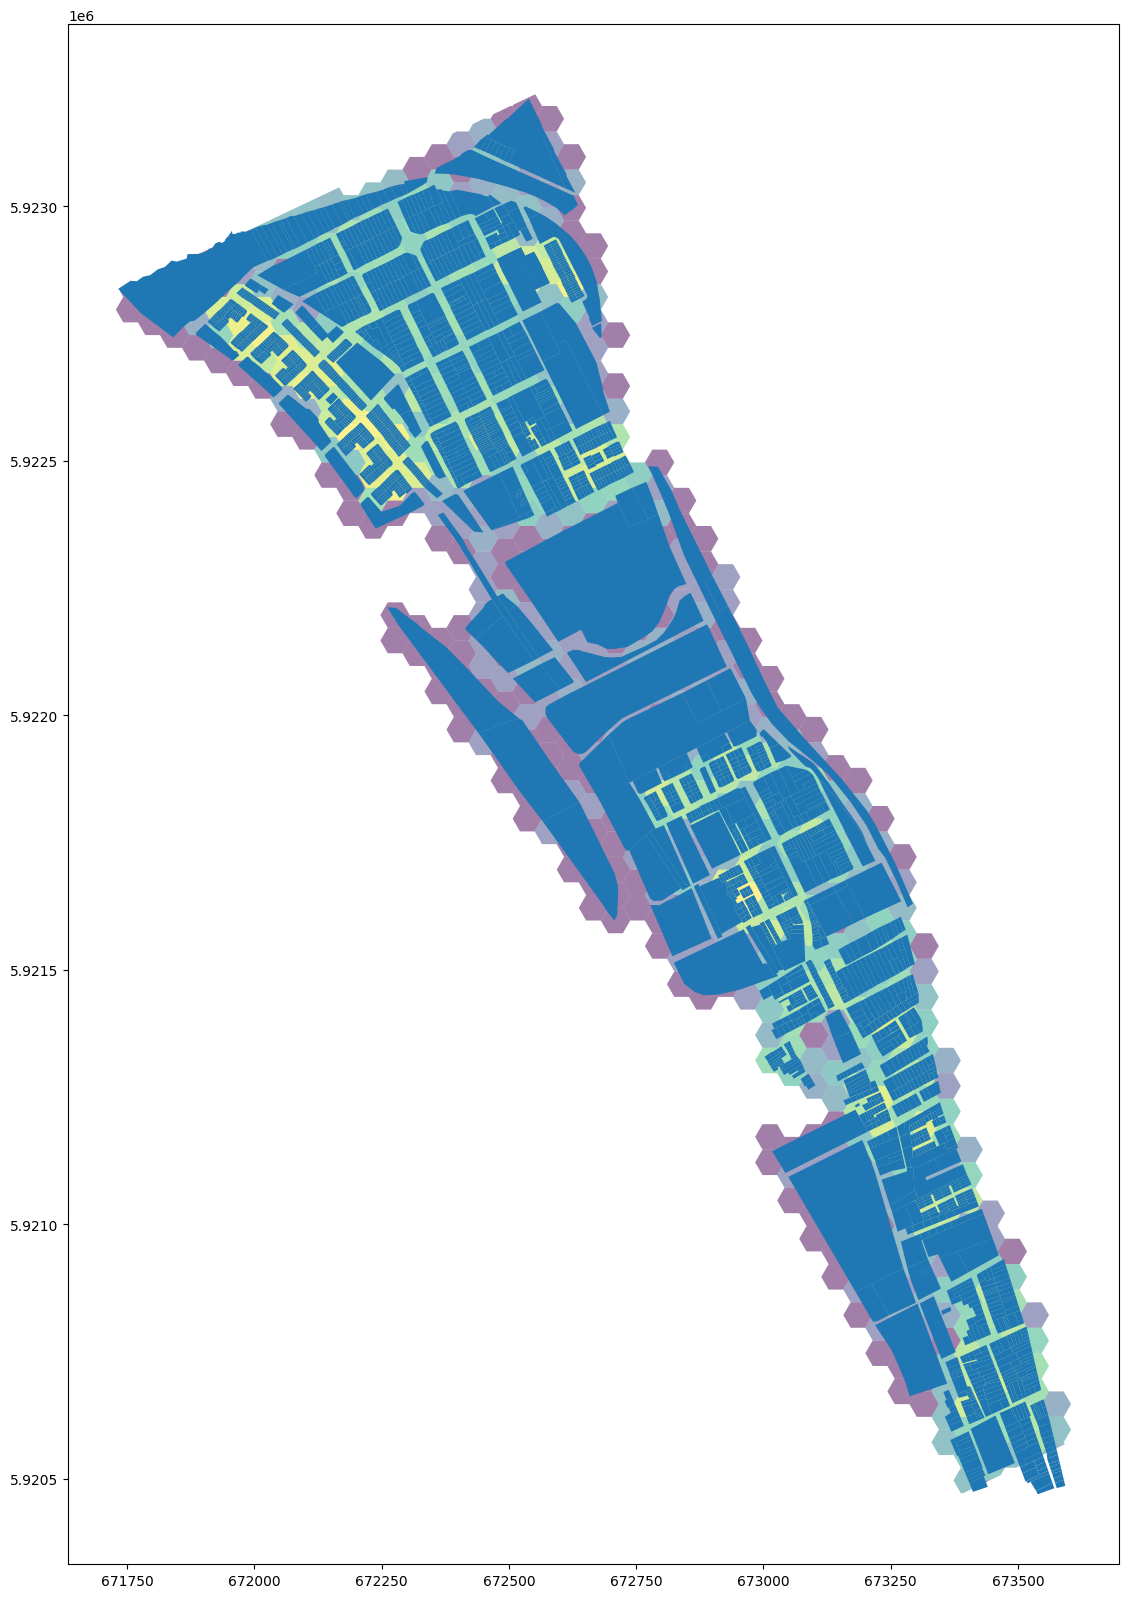

In [134]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,20))
diversity_map.plot(column='diversity', ax=ax, alpha=0.5)
gdf.plot(ax=ax)
total_hect = gdf['area_predio'].sum()
diversity_indicator = diversity_map['diversity'].sum()/total_hect
print(diversity_indicator)

0.0009459022283520968


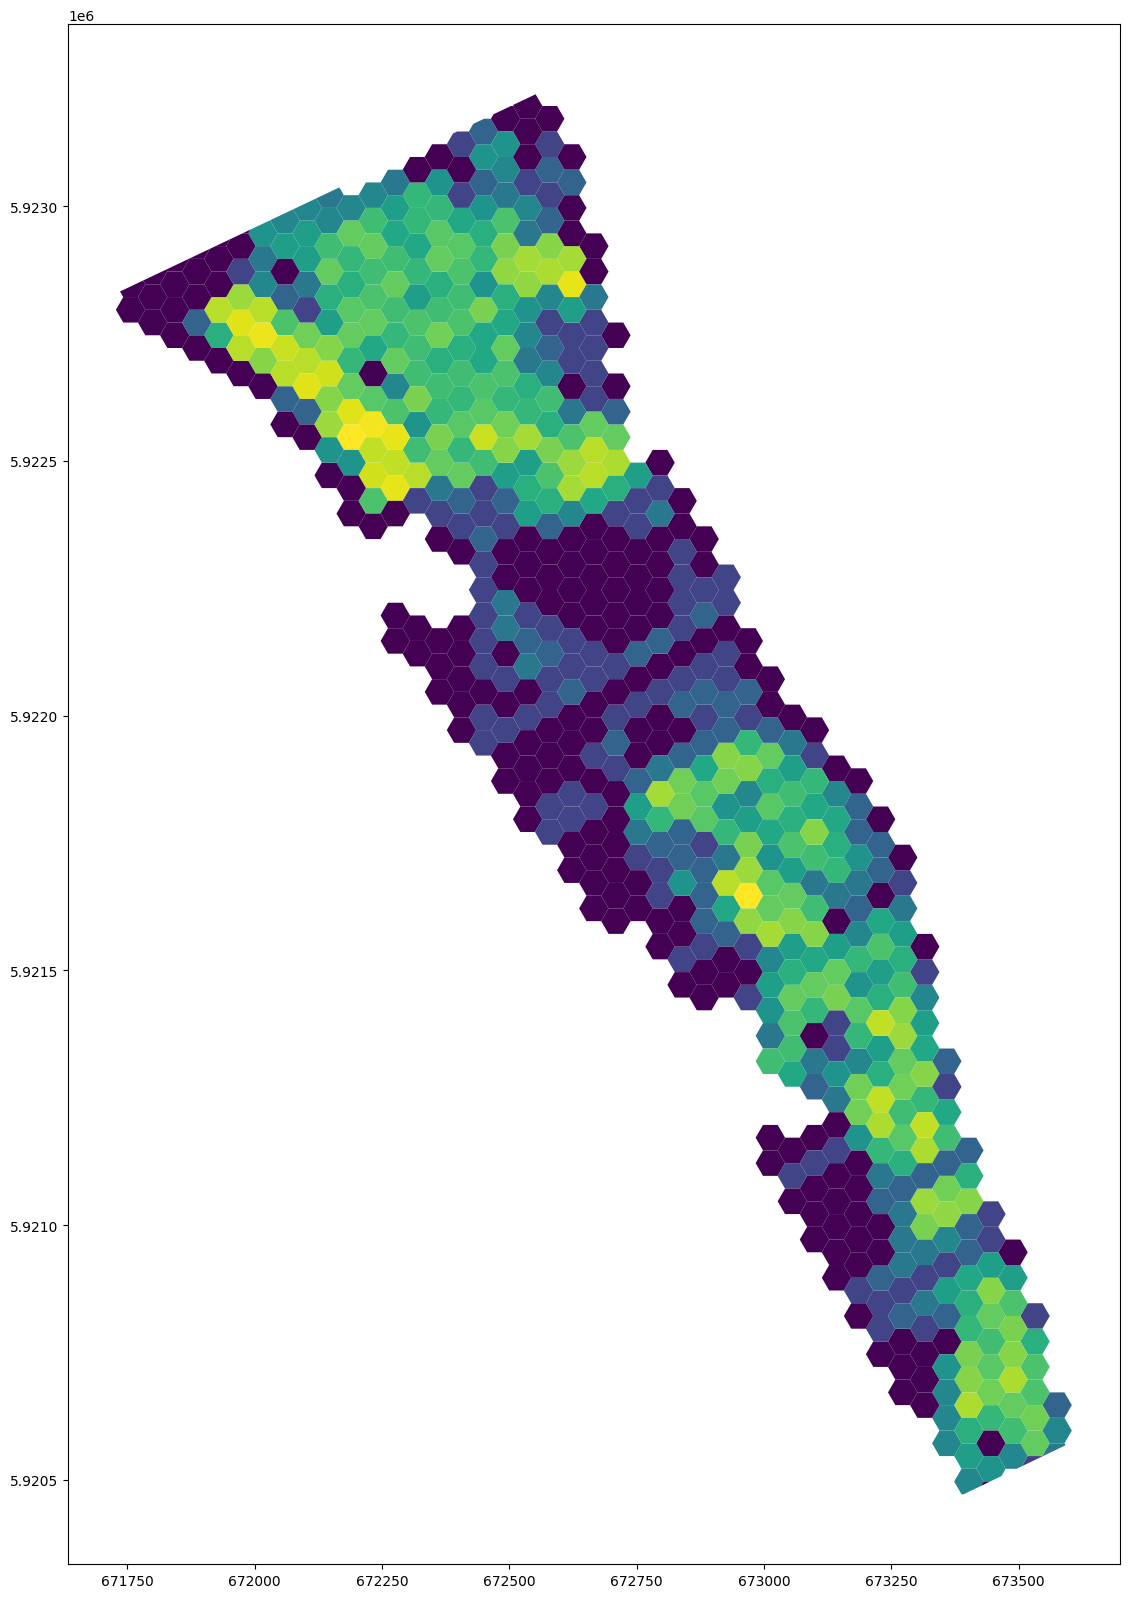

In [135]:
diversity_map.plot(column='diversity', figsize=(20,20))
total_hect = gdf['area_predio'].sum()
diversity_indicator = diversity_map['diversity'].sum()/total_hect
print(diversity_indicator)

# Identify actual and future land_uses in plates

In [136]:
future_land_uses = gpd.read_file('/app/assets/land_uses/future')

In [137]:
n_plate = '6'
# for n_plate in range(8):
plate = gpd.read_file(f'/app/assets/plates/{n_plate}').to_crs(default_crs)

In [138]:
# lands_to_change = gpd.sjoin(gdf, plate, how='inner')
lands_to_change = gpd.sjoin(future_land_uses, plate, how='inner')

<Axes: >

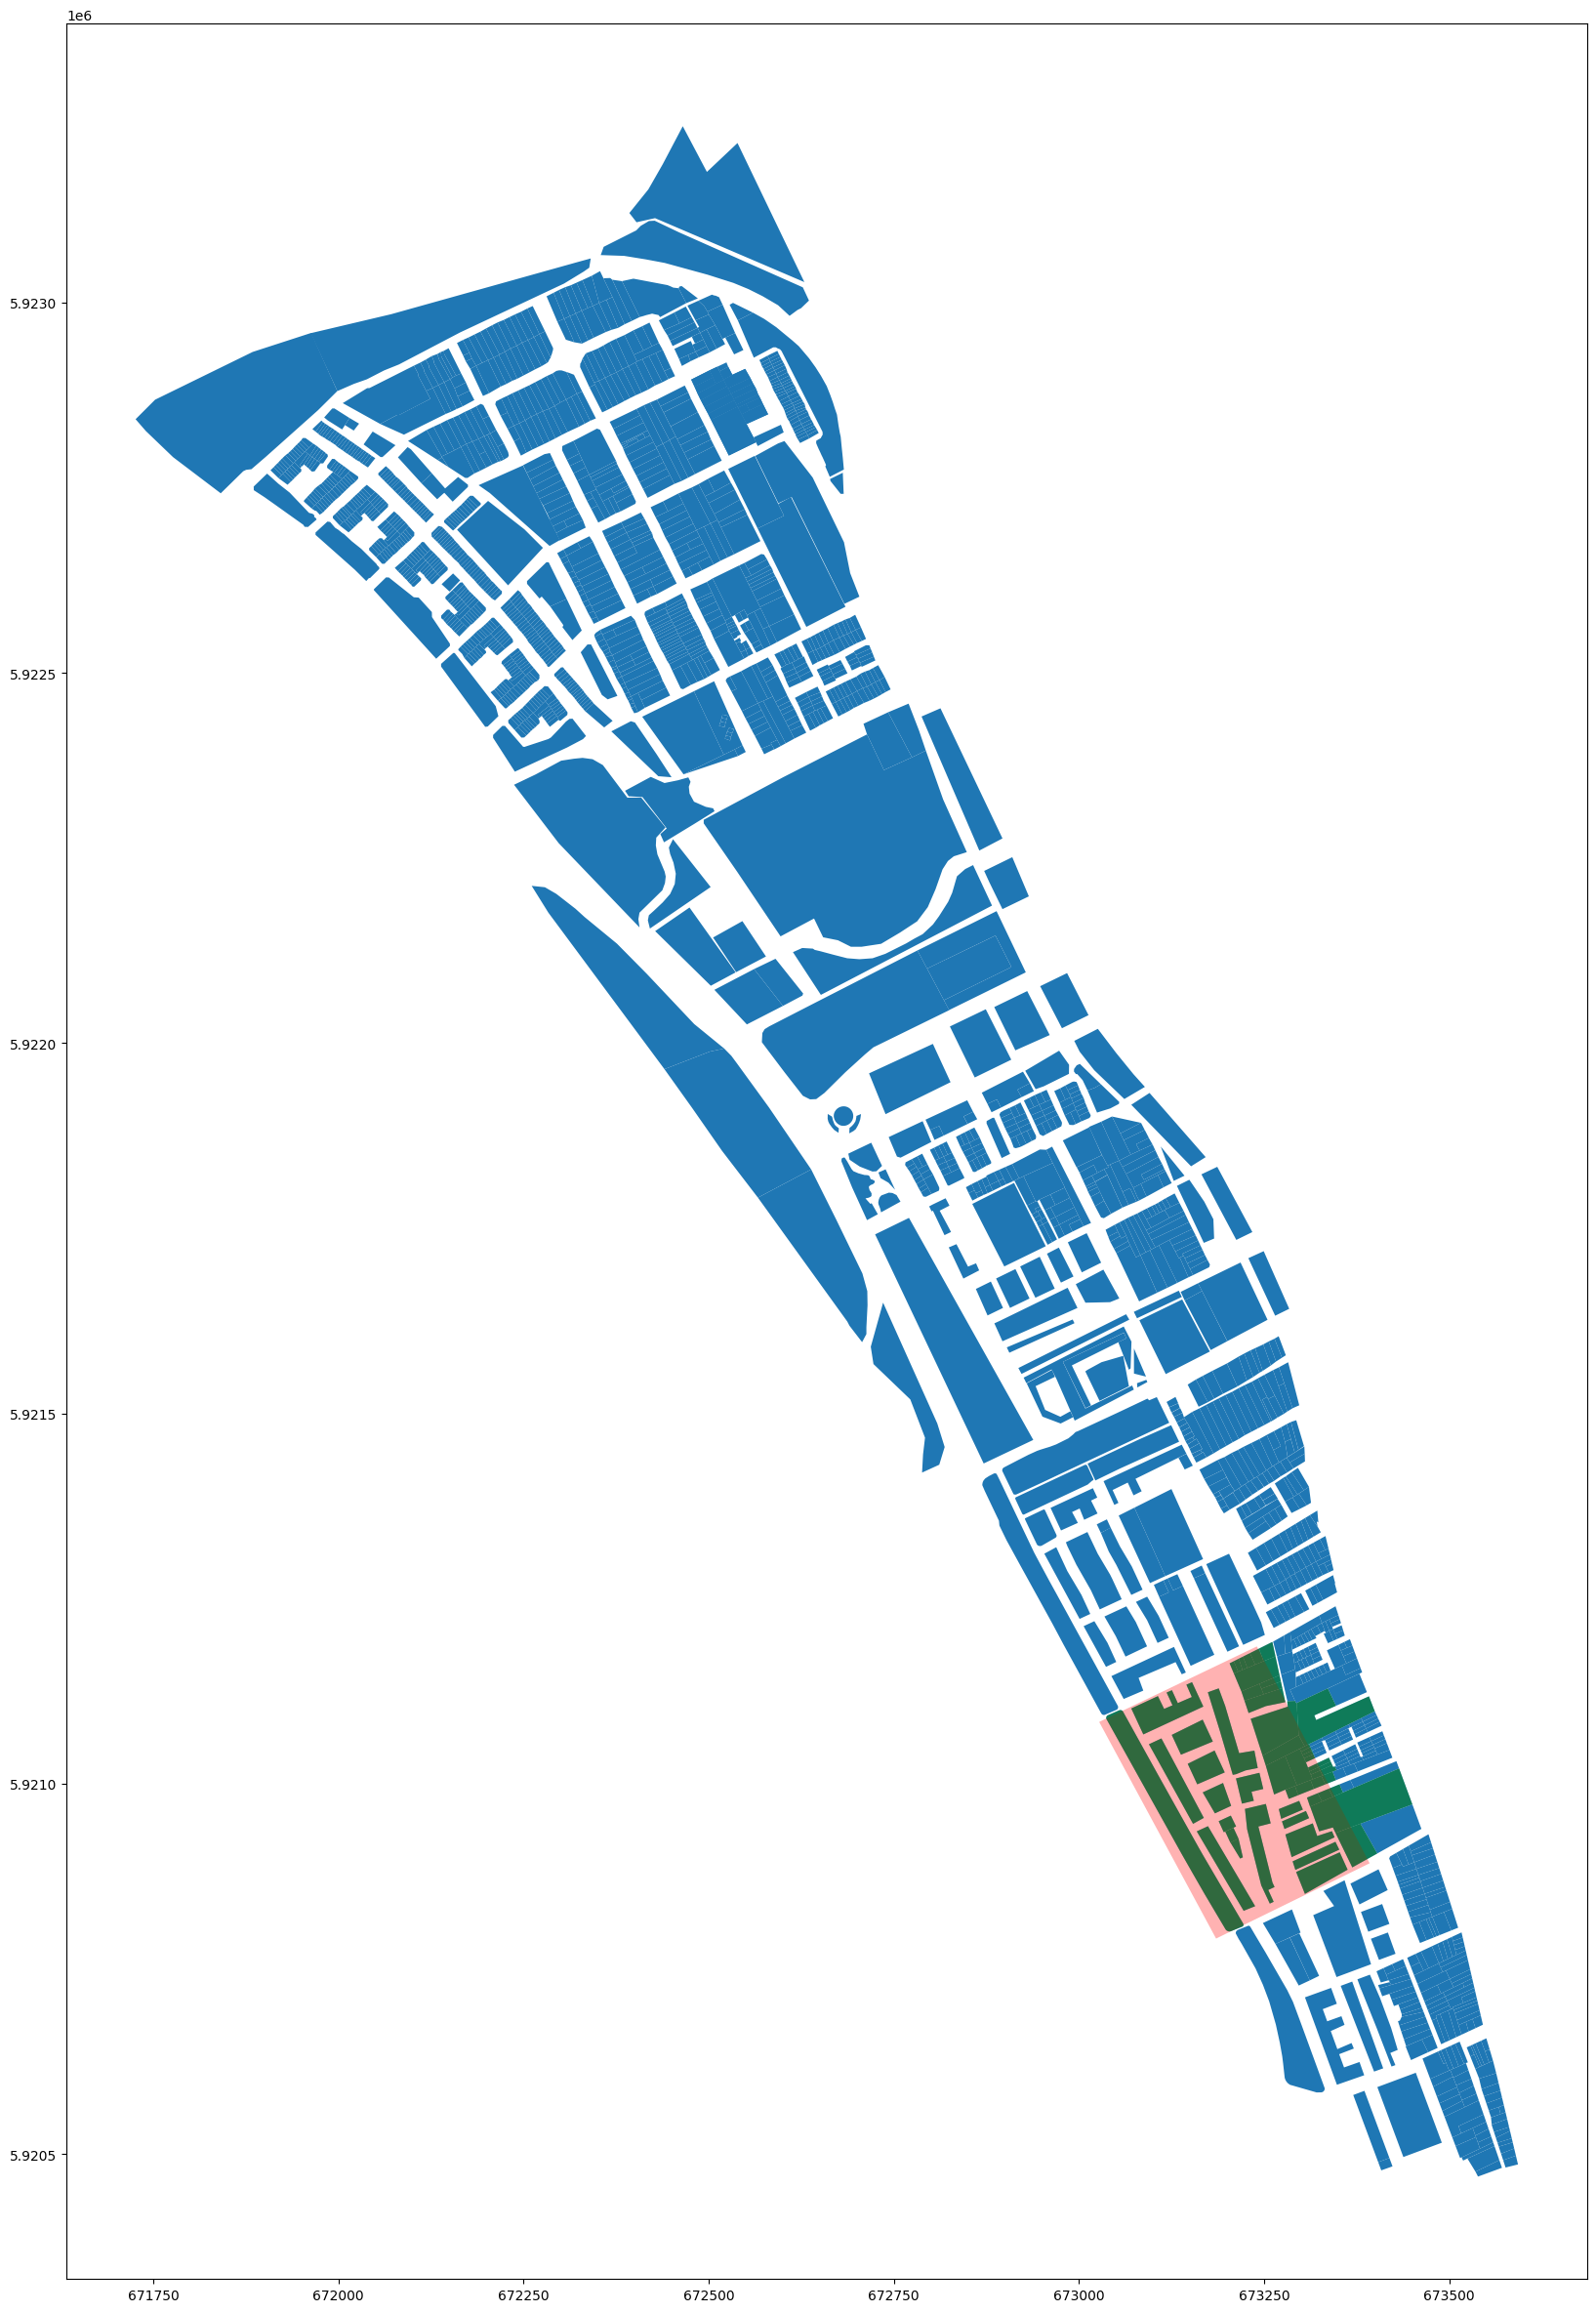

In [139]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(30,30))
future_land_uses.plot(ax=ax)
plate.plot(ax=ax, color='red', alpha=0.3)
lands_to_change.plot(ax=ax, color='green', alpha=0.5)
# gdf[gdf.index.isin(lands_to_change.index)].plot(ax=ax, color='purple', alpha=0.1)

In [140]:
future_land_uses

,Id,Uso,geometry
0,0.0,ÁREAS VERDES,"POLYGON ((672896.450 5921422.365, 672896.367 5..."
1,0.0,ÁREAS VERDES,"POLYGON ((672892.311 5921411.225, 672896.228 5..."
2,0.0,HABITACIONAL,"POLYGON ((672914.226 5921386.351, 672914.827 5..."
3,0.0,HABITACIONAL,"POLYGON ((673011.672 5921432.261, 673035.113 5..."
4,0.0,HABITACIONAL,"POLYGON ((672927.394 5921358.528, 672949.302 5..."
...,...,...,...
1810,0.0,HABITACIONAL,"POLYGON ((673008.711 5921649.571, 672995.668 5..."
1811,0.0,ÁREAS VERDES,"POLYGON ((673074.265 5921587.735, 673090.511 5..."
1812,0.0,ÁREAS VERDES,"POLYGON ((673078.842 5921535.108, 673078.384 5..."
1813,0.0,ÁREAS VERDES,"POLYGON ((672849.591 5921890.993, 672844.213 5..."
